# Desafio final

Este projeto tem como objetivo realizar uma análise abrangente do consumo de energia elétrica no Brasil, utilizando dados de 2004 a 2023. O desafio consiste em explorar padrões de consumo energético, identificar tendências ao longo do tempo e investigar possíveis correlações com fatores socioeconômicos e geográficos. Através de técnicas de análise exploratória de dados e visualizações informativas, buscaremos compreender as variações no consumo entre diferentes estados, regiões e tipos de consumidores. Além disso, examinaremos a influência de fatores como população e desenvolvimento econômico no consumo de energia. Esta análise visa fornecer insights valiosos sobre o panorama energético brasileiro, contribuindo para uma compreensão mais profunda dos padrões de consumo e potencialmente auxiliando na formulação de políticas energéticas mais eficientes e sustentáveis. Para transparência, esse desafio foi feito de forma colaborativa com inteligência artificial em questões de estrutura e estilos claros e concisos da linguagem Python, buscando sempre que possível o pep-8.

In [55]:
# para começar com o pé direito
print('Hello, world!')

Hello, world!


## Estrutura de arquivos

Antes de mergulharmos na análise do consumo energético brasileiro, é crucial estabelecer uma base sólida para nosso projeto. Uma estrutura organizada e um sistema de versionamento eficiente são fundamentais para garantir a integridade e reprodutibilidade do nosso trabalho.

Para este projeto, adotei a seguinte estrutura de diretórios:

![Estrutura de diretórios e arquivos](../imagens/estrutura_inicio.png)

Esta organização permite uma clara separação entre dados brutos, processados e o código de análise, facilitando a navegação e manutenção do projeto.

Além disso, utilizo o GitHub para controle de versão, o que não só previne perdas acidentais, mas também abre portas para colaborações futuras. Um arquivo `.gitignore` foi configurado para excluir a pasta do ambiente virtual do versionamento, mantendo nosso repositório enxuto e focado apenas nos elementos essenciais do projeto.

Com esta base estabelecida, estamos prontos para iniciar nossa análise do consumo energético no Brasil, assegurando que nosso trabalho seja organizado, rastreável e colaborativo.

## Bibliotecas usadas

In [56]:
# análise e manipulação de dataframes
import pandas as pd
# geração de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

## Preparação

### Criação dos dataframes iniciais

Para importar os dataframes, vamos dar uma breve olhada nos arquivos. Para isso vou abrir o arquivo csv no próprio VS Code, para saber qual é o separador:

![visualização do arquivo csv](../imagens/qual_separador.png)

Podemos ver que o separador é vírgula e que há arquivos ausentes já que tem duas vígulas na sequencia nos primeiros dados.

Agora usando a extensão DataWrangler:

![Visualização do CSV pelo DataWangler](../imagens/entendo_dataset_dw.png)

Podemos ver que em consumidores temos quase 1/3 de dados ausentes, isso é importante na nossa análise, voltaremos a isso logo mais.

### Importando os dados de energia elétrica

In [57]:
# importando o dataset de energia com o seperador por vírgulas
dataset_energia =  pd.read_csv('../dados/brutos/consumo_energia_eletrica.csv', sep=',', encoding='utf-8')

### Análise de dados ausentes e duplicados para energia elétrica

Vamos criar uma função que verifica a quantidade de dados ausentes para as colunas desse dataframe, com base nos resultados que obtivermos, vamos decidir qual abordagem tomar.

In [58]:
def analise_dados_ausentes(df, crescente=False, tamanho_figura=(10, 6)):
    """
    Analisa e visualiza dados ausentes em um DataFrame.

    Args:
    df (pd.DataFrame): O DataFrame a ser analisado.
    crescente (bool): Se True, ordena do menor para o maior. Se False, do maior para o menor.
    tamanho_figura (tuple): Tamanho da figura do gráfico.

    Returns:
    None
    """
    # Calcular o número de valores ausentes por coluna
    valores_ausentes = df.isnull().sum().sort_values(ascending=crescente)
    
    # Calcular a porcentagem de valores ausentes
    porcentagens_ausentes = 100 * df.isnull().sum() / len(df)
    porcentagens_ausentes = porcentagens_ausentes.sort_values(ascending=crescente)

    # Criar o gráfico de barras horizontal
    plt.figure(figsize=tamanho_figura, facecolor='white')
    ax = valores_ausentes.plot(kind='barh', color='#4a4a4a')
    
    # Remover bordas
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Remover ticks do eixo y
    ax.tick_params(axis='y', which='both', left=False)
    
    # Adicionar valores
    for i, v in enumerate(valores_ausentes):
        ax.text(v, i, f' {v}', va='center')
    
    # Informações de títulos e rótulos
    plt.title('Quantidade de Dados Ausentes por Coluna', fontsize=14, pad=20)
    plt.xlabel('Número de Dados Ausentes', fontsize=12, labelpad=10)
    plt.ylabel('')  # Remover label do eixo y
    plt.tight_layout()
    plt.show()

    # Imprimir as porcentagens de dados ausentes
    print("\nPorcentagem de Dados Ausentes por Coluna:")
    for col, porcentagem in porcentagens_ausentes.items():
        print(f"{col}: {porcentagem:.2f}%")

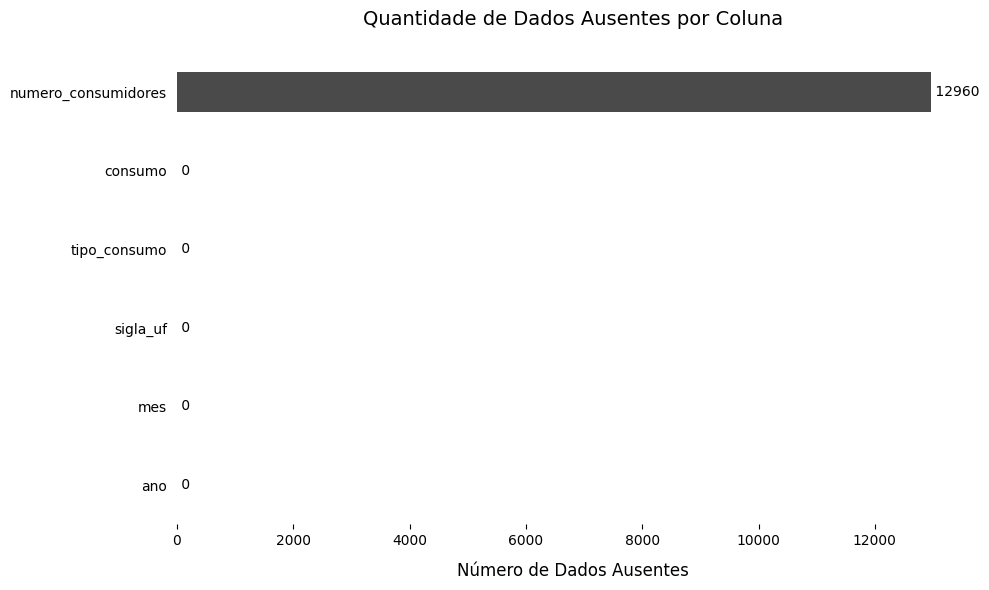


Porcentagem de Dados Ausentes por Coluna:
ano: 0.00%
mes: 0.00%
sigla_uf: 0.00%
tipo_consumo: 0.00%
consumo: 0.00%
numero_consumidores: 32.48%


In [59]:
analise_dados_ausentes(dataset_energia, True)

Temos 32% de dados ausentes na coluna "numero_consumidores", vamos analisar o comportamento desses dados ausentes, se é aleatório ou está concentrado.

In [62]:
filtro_ausente = dataset_energia['numero_consumidores'].isnull() == True

In [63]:
dataset_energia[filtro_ausente]

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,TO,Total,NaN,65876
1,2004,1,BA,Total,NaN,1444451
2,2004,1,PR,Total,NaN,1596274
3,2004,1,RS,Total,NaN,1780912
4,2004,1,GO,Total,NaN,630624
...,...,...,...,...,...,...
37579,2023,12,DF,Cativo,NaN,503565
37580,2023,12,MT,Cativo,NaN,732101
37581,2023,12,RR,Cativo,NaN,112337
37582,2023,12,CE,Cativo,NaN,887204


In [87]:
dataset_energia[filtro_ausente].groupby('ano')['ano'].value_counts()

ano
2004    648
2005    648
2006    648
2007    648
2008    648
2009    648
2010    648
2011    648
2012    648
2013    648
2014    648
2015    648
2016    648
2017    648
2018    648
2019    648
2020    648
2021    648
2022    648
2023    648
Name: count, dtype: int64

Não há concentração de dados ausentes por ano. Cada ano tem exatamente o mesmo valor de dados ausentes. Vamos verificar outras variáveis, como "tipo_consumo".

In [122]:
tipos = dataset_energia['tipo_consumo'].unique()
for tipo in tipos:
  print(f'{tipo} = {len(dataset_energia[dataset_energia['tipo_consumo'] == tipo].value_counts())}')

Total = 0
Cativo = 0
Outros = 6480
Comercial = 6480
Industrial = 6480
Residencial = 6480


Total e Cativo não tem valores ao longo de todo o dataframe e eles compoõe os 12960 valores que faltam no dataframe.

Vamos tentar entender o funcionamento desses valores. Podemos inputar valores para Total uma vez que total é a soma de partes? Mas e o Cativo? 

In [ ]:
filtro_ano1 = (dataset_energia['ano'] == 2004) & (dataset_energia['sigla_uf'] == 'TO') & (dataset_energia['mes'] == 2)
dataset_energia[filtro_ano]

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
52,2004,2,TO,Total,NaN,63306
356,2004,2,TO,Cativo,NaN,63306
698,2004,2,TO,Outros,22324.0,19893
1025,2004,2,TO,Comercial,26102.0,12160
1333,2004,2,TO,Industrial,2411.0,7267
1654,2004,2,TO,Residencial,233251.0,23986


Nessa amostra podemos perceber que o consumo dos tipos Residencial, Industrial, Comercial e Outros são equivalentes ao Total e que Cativo tem o mesmo valor de Total.

In [130]:
filtro_ano2 = (dataset_energia['ano'] == 2007) & (dataset_energia['sigla_uf'] == 'SP') & (dataset_energia['mes'] == 10)
dataset_energia[filtro_ano2]

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
6089,2007,10,SP,Total,NaN,9865949
6424,2007,10,SP,Cativo,NaN,6967375
6738,2007,10,SP,Outros,359118.0,1144287
7051,2007,10,SP,Comercial,987792.0,1658788
7379,2007,10,SP,Industrial,122726.0,4590297
7699,2007,10,SP,Residencial,12901623.0,2472577


Nessa outra amostra, novamente o consumo dos tipos Residencial (R), Industrial (I), Comercial (C) e Outros (O) equivale ao Total (Tot), e dessa vez Cativo (Cat) não tem o mesmo valor, mas é um valor menor. Podemos deduzir que Cativo é uma representação especial que engloba os outros tipos de consumo, de forma que, Tipos R, I, C e O totalizam Tot e que desse Tot, n% são Cat. 

In [60]:
import pandas as pd

def identifica_duplicatas(dataframe, resumido=True):
    """
    Identifica e exibe as linhas duplicadas em um DataFrame.
    
    Args:
    dataframe (pd.DataFrame): O DataFrame a ser analisado.
    resumido (bool): Se True, exibe um resumo padrão. Se False, exibe todas as linhas duplicadas agrupadas.
    
    Returns:
    pd.DataFrame: DataFrame contendo as linhas duplicadas.
    """
    # Identificar todas as linhas duplicadas
    duplicados = dataframe[dataframe.duplicated(keep=False)]

    # Ordenar as duplicatas para agrupar as linhas idênticas
    duplicados_ordenados = duplicados.sort_values(by=dataframe.columns.tolist())

    if resumido:
        # Exibir as duplicatas no formato resumido padrão do pandas
        quantidade_duplicados = dataframe.duplicated().sum()
        print(f'Foram encontradas {quantidade_duplicados} duplicatas, para ver todas as duplicatas, configure o parâmetro "resumido para False"')
        print("-" * 80)  # Linha separadora entre grupos
        print(duplicados_ordenados)
    else:
        # Configurar o pandas para mostrar todas as colunas
        with pd.option_context('display.max_columns', None, 'display.width', None):
            # Agrupar as duplicatas
            grupos = duplicados_ordenados.groupby(duplicados_ordenados.columns.tolist())
            
            for _, grupo in grupos:
                print("Grupo de linhas duplicadas:")
                for index, row in grupo.iterrows():
                    print(f"Linha {index}:")
                    print(row.to_frame().T)  # Transforma a Series em um DataFrame de uma linha
                print("-" * 80)  # Linha separadora entre grupos
                print()  # Linha em branco para melhor legibilidade



In [61]:
identifica_duplicatas(dataset_energia, True)

Foram encontradas 1017 duplicatas, para ver todas as duplicatas, configure o parâmetro "resumido para False"
--------------------------------------------------------------------------------
        ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
37912  2023    1       AC    Comercial              23174.0    21629
38929  2023    1       AC    Comercial              23174.0    21629
38247  2023    1       AC   Industrial                299.0     3803
39264  2023    1       AC   Industrial                299.0     3803
38574  2023    1       AC  Residencial             240560.0    47887
...     ...  ...      ...          ...                  ...      ...
39550  2023   12       TO   Industrial               1413.0    35417
37888  2023   12       TO       Outros              53923.0    51090
38905  2023   12       TO       Outros              53923.0    51090
38856  2023   12       TO  Residencial             576079.0   119941
39873  2023   12       TO  Residencial             